In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate2d
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
import cv2
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import cv2
import concurrent.futures

Mounted at /content/drive


In [ ]:
# Define paths
models_path = '/content/drive/MyDrive/ipcv_project_files/models/'
scenes_path = '/content/drive/MyDrive/ipcv_project_files/pics/'


# Load reference images
patterns = [os.path.join(models_path, f'ref{i}.png') for i in range(15, 28)]
model_images = {}

# Iterate over each pattern and add matching images to the model_images dictionary
for pattern in patterns:
    for img_path in glob.glob(pattern):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        model_images[os.path.basename(img_path)] = img

# Load scene images
scene_images = []
for img_path in glob.glob(os.path.join(scenes_path, '*.jpg')):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    scene_images.append((os.path.basename(img_path), img))

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Function to detect and compute features
def detect_and_compute(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

# Extract features from reference images
model_keypoints_descriptors = {}
for name, img in model_images.items():
    keypoints, descriptors = detect_and_compute(img)
    model_keypoints_descriptors[name] = (img, keypoints, descriptors)

# Extract features from scene images
scene_keypoints_descriptors = []
for name, img in scene_images:
    keypoints, descriptors = detect_and_compute(img)
    scene_keypoints_descriptors.append((name, img, keypoints, descriptors))


# Function to draw bounding boxes
def draw_bounding_boxes(image, detections):
    for det in detections:
        position = det["position"]
        width = det["width"]
        height = det["height"]
        top_left = (int(position[0] - height / 2), int(position[1] - width / 2))
        bottom_right = (int(position[0] + height / 2), int(position[1] + width / 2))
        cv2.rectangle(image, top_left, bottom_right, (0, 0, 255), 10)  # Red rectangle with thickness 2

# Process each scene image

def match_features(desc1, desc2, lowe_ratio=0.75):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < lowe_ratio * n.distance:
            good_matches.append(m)
    return good_matches

def debug_print(ref, num_matches, center, width, height):
    pass
    #if ref_name in ["ref23", "ref26", "ref17"]:
        #pri
        #print(f"---{ref}---  Debugging {ref_name}:")
        #print(f"  Number of matches: {num_matches}")
        #print(f"  Center: {center}")
        #print(f"  Width: {width}")
        #print(f"  Height: {height}")



def non_maximum_suppression(detections, iou_threshold=0.5):
    if len(detections) == 0:
        return []

    # Extract positions and confidence scores
    boxes = np.array([d["position"] + [d["width"], d["height"]] for d in detections])
    scores = np.array([d["confidence"] for d in detections])
    refc = np.array([d["class"] for d in detections])


    # Calculate areas of the bounding boxes
    areas = boxes[:, 2] * boxes[:, 3]
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(detections[i])
        xx1 = np.maximum(boxes[i, 0], boxes[order[1:], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[order[1:], 1])
        xx2 = np.minimum(boxes[i, 0] + boxes[i, 2], boxes[order[1:], 0] + boxes[order[1:], 2])
        yy2 = np.minimum(boxes[i, 1] + boxes[i, 3], boxes[order[1:], 1] + boxes[order[1:], 3])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(iou <= iou_threshold)[0]
        #print("N")
        order = order[inds + 1]

    return keep


def generalized_hough_transform(model_img, model_kp, model_desc, scene_img, scene_kp, scene_desc, lowe_ratio, thr=40):
    matches = match_features(model_desc, scene_desc, lowe_ratio)
    num_matches = len(matches)
    ref_name = "a"
    if num_matches < thr:
        debug_print("**** # Not enough matches", num_matches, None, None, None)
        return None, None, None, 0  # Return 0 as confidence if matches are less than threshold

    src_pts = np.float32([model_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Use RANSAC to find a robust homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if M is None:
        debug_print("****M None", num_matches, None, None, None )  # Homography is None
        return None, None, None, 0  # Return 0 as confidence if homography is None

    # Get dimensions of the model image
    h, w = model_img.shape[:2]
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    # Calculate bounding box parameters
    center = np.mean(dst, axis=0).flatten()
    width = np.linalg.norm(dst[0] - dst[1])
    height = np.linalg.norm(dst[1] - dst[2])

    # Debug prints for bounding box dimensions
    debug_print("what???", num_matches, center, width, height)

    # Verification step to filter out unrealistic bounding boxes
    if (width > 600 and height > 600) or (width > 1200 or height > 1200):
        debug_print("Bounding box too large", num_matches, center, width, height)
        return None, None, None, 0
    if width < 250 and height < 250:
        debug_print("Bounding box too small", num_matches, center, width, height)
        return None, None, None, 0
    if width < 100 or height < 100:
        debug_print("Bounding box too small", num_matches, center, width, height)
        return None, None, None, 0
    if center[0] < 0 or center[1] < 0:
        debug_print("Bounding box center out of bounds", num_matches, center, width, height)
        return None, None, None, 0

    return center, width, height, num_matches  # Use the number of matches as the confidence score

'def lets_break_it_down(scene_number=0, iou_threshold=0.2, thr=40, lowe_thr=0.75):\n    results = {}\n    ids = scene_number\n    counter = 0\n    output_dir = "/kaggle/working/out/"\n    if not os.path.exists(output_dir):\n        os.makedirs(output_dir)\n\n    for scene_name, scene_img, scene_kp, scene_desc in scene_keypoints_descriptors:\n\n        if counter == ids:\n            scene_results = []\n            for ref_name, (ref_img, ref_kp, ref_desc) in model_keypoints_descriptors.items():\n                center, width, height, conf = generalized_hough_transform(ref_img, ref_kp, ref_desc, scene_img, scene_kp, scene_desc, thr=thr, lowe_ratio=lowe_thr)\n\n                # Debug prints for detection results\n                if center is not None:\n                    #print(f"Model {ref_name} detected in scene {scene_name} with confidence {conf}")\n                    #print(f"Bounding box center: {center}, width: {width}, height: {height}")\n\n                    detection = {\n  

In [ ]:
def non_max_suppression(detections, iou_threshold=0.5):
      sorted_detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
      #print(sorted_detections)
      kept_detections = []

      for detection in sorted_detections:
          should_keep = True
          for kept_detection in kept_detections:
              iou = calculate_iou(
                  (detection['position'][0], detection['position'][1], detection['width'], detection['height']),
                  (kept_detection['position'][0], kept_detection['position'][1], kept_detection['width'], kept_detection['height'])
              )
              if iou[0] > iou_threshold and iou[1] > iou_threshold:
                  should_keep = False
                  break
          if should_keep:
              print("its saving",detection)
              kept_detections.append(detection)

      return kept_detections

def lets_break_it_down(scene_number=0, iou_threshold=0.2, thr=40, lowe_thr=0.75, shower= False):
    results = {}
    ids = scene_number
    counter = 0

    for scene_name, scene_img, scene_kp, scene_desc in scene_keypoints_descriptors:

        if counter == ids:
            scene_results = []
            for ref_name, (ref_img, ref_kp, ref_desc) in model_keypoints_descriptors.items():
                center, width, height, conf = generalized_hough_transform(ref_img, ref_kp, ref_desc, scene_img, scene_kp, scene_desc, thr=thr, lowe_ratio=lowe_thr)

                if center is not None:
                    detection = {
                        "position": [center[0], center[1]],
                        "width": width,
                        "height": height,
                        "confidence": conf,  # Use the number of matches as the confidence score
                        "class": ref_name
                    }
                    scene_results.append(detection)

            # Apply Non-Maximum Suppression to filter overlapping detections
            final_detections = non_maximum_suppression(scene_results, iou_threshold)

            # Draw bounding boxes on the scene image
            copyim = scene_img.copy()
            draw_bounding_boxes(copyim, final_detections)

            cv2.imwrite(save_path, copyim)

            results[scene_name] = final_detections

            if shower:
              # Display the result using matplotlib
              plt.figure(figsize=(10, 10))
              plt.imshow(cv2.cvtColor(copyim, cv2.COLOR_BGR2RGB))
              plt.title(f"Detections in {scene_name}")
              plt.axis('off')
              plt.show()
            counter += 1

        else:
            counter += 1

    return results

def calculate_iou(box1, box2):
    # Calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    union = area1 + area2 - intersection

    # Calculate IoU
    iou = intersection / union if union > 0 else 0
    return iou


def generate_report(detections):
    # Group detections by class
    grouped_detections = {}
    for detection in detections:
        class_name = detection['class']
        if class_name not in grouped_detections:
            grouped_detections[class_name] = []
        grouped_detections[class_name].append(detection)

    # Generate the report string
    report = ""
    product_count = 0
    for class_name, instances in grouped_detections.items():
        report += f"Product {class_name} - {len(instances)} instance(s) found:\n"
        for idx, instance in enumerate(instances, 1):
            position = instance['position']
            width = instance['width']
            height = instance['height']
            report += f"  Instance {idx} {{position: {position}, width: {width}px, height: {height}px}}\n"
        product_count += 1

    return report


In [ ]:
def match_features(desc1, desc2, lowe_ratio=0.75):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < lowe_ratio * n.distance:
            good_matches.append(m)
    return good_matches

def rgb_sift(image):
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []

    for channel in cv2.split(image):
        kp, des = sift.detectAndCompute(channel, None)
        keypoints.append(kp)
        descriptors.append(des)

    return keypoints, descriptors

def rgb_sift_similarity(template, image):
    kp1, des1 = rgb_sift(template)
    kp2, des2 = rgb_sift(image)

    bf = cv2.BFMatcher()
    matches = []

    for d1, d2 in zip(des1, des2):
        if d1 is not None and d2 is not None:
            matches.extend(bf.knnMatch(d1, d2, k=2))

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    similarity = len(good_matches) / max(len(kp1[0]), len(kp2[0]))
    return similarity

def calculate_histogram(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Calculate the histogram
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [50, 60, 60], [0, 180, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def compare_histograms(hist1, hist2):
    # Use correlation as the similarity measure
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

def do_hist_sim(img1, img2):
    hist1 = calculate_histogram(img1)
    hist2 = calculate_histogram(img2)

    return compare_histograms(hist1, hist2)

def color_histogram_similarity(template, image_region):
    template_hist = cv2.calcHist([template], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    image_hist = cv2.calcHist([image_region], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    similarity = cv2.compareHist(template_hist, image_hist, cv2.HISTCMP_CORREL)
    return similarity

def color_based_search(template, image, grid_layers, threshold=0.7):
    detections = []
    for layer in grid_layers:
        for cell in layer:
            score = color_histogram_similarity(template, image[cell[0]:cell[1], cell[2]:cell[3]])
            if score > threshold:
                detections.append((cell, score))
    return detections

def zncc_score(template, image):
    return cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)
def notzncc_score(template, image):
    return ssim(template, image, channel_axis=2)

def ssim_similarity(template, image):
    return ssim(template, image, multichannel=True)

def perform_multi_instance_detection(initial_detections, scene_img, model_keypoints_descriptors, iou=0.5, dist=10, zncc_threshold=0.7, confidance_thr= -1):
    def find_best_position(x, y, w, h, ref_class, step_size=5, step_sizeY= 5, curr_score= -1):
        best_score = curr_score
        best_pos = (x, y)
        for dx in range(-2*step_size, 2*step_size + 1):
            for dy in range(-step_sizeY, step_sizeY + 1):
                new_x, new_y = x + dx, y + dy
                roi = scene_gray[int(new_y - w/2):int(new_y + w/2), int(new_x - h/2):int(new_x + h/2)]
                if roi.shape[0] > 0 and roi.shape[1] > 0:
                    template = cv2.resize(cv2.cvtColor(model_keypoints_descriptors[ref_class][0], cv2.COLOR_BGR2GRAY), (int(roi.shape[1]), int(roi.shape[0])))
                    score = zncc_score(template, roi).max()
                    if score > best_score:
                        best_score = score
                        best_pos = (new_x, new_y)
        return best_pos, best_score
    def non_max_suppression(detections, iou_threshold):
      sorted_detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
      kept_detections = []

      for detection in sorted_detections:
          should_keep = True
          for kept_detection in kept_detections:
              iou = calculate_iou(
                  (detection['position'][0], detection['position'][1], detection['width'], detection['height']),
                  (kept_detection['position'][0], kept_detection['position'][1], kept_detection['width'], kept_detection['height'])
              )
              if iou > iou_threshold:
                  should_keep = False
                  break
          if should_keep:
              kept_detections.append(detection)

      return kept_detections

    def calculate_iou(box1, box2):
      # Convert to top-left format
      box1 = (box1[0] - box1[2]/2, box1[1] - box1[3]/2, box1[2], box1[3])
      box2 = (box2[0] - box2[2]/2, box2[1] - box2[3]/2, box2[2], box2[3])

      # Rest of the function remains the same
      x1 = max(box1[0], box2[0])
      y1 = max(box1[1], box2[1])
      x2 = min(box1[0] + box1[2], box2[0] + box2[2])
      y2 = min(box1[1] + box1[3], box2[1] + box2[3])
      intersection = max(0, x2 - x1) * max(0, y2 - y1)

      area1 = box1[2] * box1[3]
      area2 = box2[2] * box2[3]
      union = area1 + area2 - intersection

      iou = intersection / union if union > 0 else 0
      return iou

    scene_gray = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
    height, width = scene_gray.shape
    all_grids = []

    for i, detection in enumerate(initial_detections):
        x, y = detection["position"]
        w, h = detection["width"], detection["height"]
        class_name = detection["class"]

        # Generate grids with focus on the area between detections
        grids = []
        for dx in np.linspace(-1.5, 1.5, 20):
            for dy in np.linspace(-0.07, 0.07, 3):
                new_x = x + dx * w
                new_y = y + dy * h
                grids.append((new_x, new_y, w, h))


        # Remove grids that are completely outside the image
        grids = [grid for grid in grids if not (grid[0] - grid[3]/2 < 0 or grid[1] - grid[2]/2 < 0 or
                                                grid[0] + grid[3]/2 > width or grid[1] + grid[2]/2 > height)]

        # Remove grids that have high overlap with initial detections
        grids = [grid for grid in grids if not any(calculate_iou(
            (grid[0] - grid[3]/2, grid[1] - grid[2]/2, grid[3], grid[2]),
            (d["position"][0] - d["height"]/2, d["position"][1] - d["width"]/2, d["height"], d["width"])) > 0.5 for d in initial_detections)]

        all_grids.extend((grid, class_name) for grid in grids)


    # Calculate similarity for all grids
    def process_grid(grid_info):
        grid, class_name = grid_info
        x, y, w, h = grid

        top = int(y - w/2)
        bottom = int(y + w/2)
        left = int(x - h/2)
        right = int(x + h/2)

        roi = scene_gray[top:bottom, left:right]
        template, _, _ = model_keypoints_descriptors[class_name]
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        template_resized = cv2.resize(template_gray, (roi.shape[1], roi.shape[0]))

        if roi.shape[0] == 0 or roi.shape[1] == 0 or roi.shape != template_resized.shape:
            return None

        score = zncc_score(template_resized, roi).max()
        return {"position": (x, y), "width": w, "height": h, "confidence": score, "class": class_name}

    grid_detections = []
    for grid_info in all_grids:
        result = process_grid(grid_info)
        if result is not None:
            grid_detections.append(result)
    grid_detections = [d for d in grid_detections if d is not None]

    # Combine initial detections and grid detections
    all_detections = initial_detections + grid_detections
    # Apply NMS to all detections
    for det in all_detections:
        x, y = det['position']
        new_pos, new_conf = find_best_position(x, y, w, h, det['class'], step_size=10, curr_score= det['confidence'])
        det['position'] = new_pos
        det['confidence'] = new_conf

    final_detections = non_max_suppression(all_detections, iou_threshold= iou)

    # Filter out low confidence detections
    final_detections = [d for d in final_detections if d['confidence'] > zncc_threshold]

    for det in final_detections:
          best_pos = det['position']
          scr = det['confidence']
          best_score = -1 #scr if scr > 1 else -1
          best_class = class_name
          local_best = -1
          for ref_class, (ref_template, _, _) in model_keypoints_descriptors.items():
              roi = scene_img[int(best_pos[1] - w/2):int(best_pos[1] + w/2), int(best_pos[0] - h/2):int(best_pos[0] + h/2), :]
              ref_resized = cv2.resize(ref_template, (roi.shape[1], roi.shape[0]))
              if roi.shape == ref_resized.shape:
                  score = rgb_sift_similarity(ref_resized, roi)
                  local_best = score if score > local_best else local_best
                  if score > best_score:
                      best_score = score
                      best_class = ref_class
                      det['class'] = best_class
                      det['confidence'] = best_score

          if best_score < confidance_thr:
              final_detections.remove(det)

    return final_detections

def process_scene(snn = 4, iou_threshold=0.3, thr=30, lowe_thr=0.7, confidance_thr= -1, iou=0.5, double_time= False, shower= False, zncc_threshold= 0.8):
  rng1, rng2 = 20, 0.7
  res3 = lets_break_it_down(scene_number=snn, iou_threshold=iou_threshold, thr=thr, lowe_thr=lowe_thr, shower= shower)
  scene_name = list(res3.keys())[0]
  initial_detections = res3[scene_name]
  scene_img = next(img for name, img, kp, desc in scene_keypoints_descriptors if name == scene_name)
  res_m = perform_multi_instance_detection(initial_detections= res3[list(res3.keys())[0]], scene_img= scene_img, model_keypoints_descriptors= model_keypoints_descriptors, iou=iou, dist= 5, zncc_threshold=zncc_threshold, confidance_thr= confidance_thr)
  if double_time:
    res_m = perform_multi_instance_detection(initial_detections= res_m, scene_img= scene_img, model_keypoints_descriptors= model_keypoints_descriptors, iou=iou, dist= 5, zncc_threshold=zncc_threshold, confidance_thr= confidance_thr)
  report = generate_report(res_m)
  print(report)
  copyim = scene_img.copy()
  draw_bounding_boxes(copyim, res_m)
  plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(copyim, cv2.COLOR_BGR2RGB))
  plt.title(f"Detections in {scene_name}")
  plt.axis('off')
  plt.show()
  return res_m


In [ ]:
FIXED_LENGTH = 100  # Fixed number of SIFT keypoints to use
HIST_BINS = [50, 60, 60]  # Fixed number of bins for the color histogram

def extract_features(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, HIST_BINS, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # SIFT feature extraction
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Ensure fixed length for SIFT descriptors
    if descriptors is not None and len(descriptors) > 0:
        if len(descriptors) > FIXED_LENGTH:
            descriptors = descriptors[:FIXED_LENGTH]
        else:
            pad_length = FIXED_LENGTH - len(descriptors)
            descriptors = np.pad(descriptors, ((0, pad_length), (0, 0)), mode='constant')
    else:
        descriptors = np.zeros((FIXED_LENGTH, 128))

    descriptors = descriptors.flatten()

    # Combine histogram and SIFT features
    combined_features = np.concatenate((hist, descriptors))
    return combined_features

def calculate_similarity(features1, features2):
    features1 = features1.reshape(1, -1)
    features2 = features2.reshape(1, -1)
    similarity = cosine_similarity(features1, features2)[0][0]
    return similarity

def classify_region(roi, ref):
    features = extract_features(roi)
    reference_features = extract_features(ref)
    similarity = calculate_similarity(features, reference_features)
    return similarity

Product ref17.png - 2 instance(s) found:
  Instance 1 {position: (649.0069, 568.6603), width: 851.5799560546875px, height: 326.3594970703125px}
  Instance 2 {position: (985.1568796258223, 568.6602783203125), width: 851.5799560546875px, height: 326.3594970703125px}
Product ref24.png - 1 instance(s) found:
  Instance 1 {position: (1338.9924, 579.1271), width: 843.572509765625px, height: 334.33245849609375px}
Product ref26.png - 1 instance(s) found:
  Instance 1 {position: (262.34332, 569.89734), width: 750.6740112304688px, height: 301.9448547363281px}



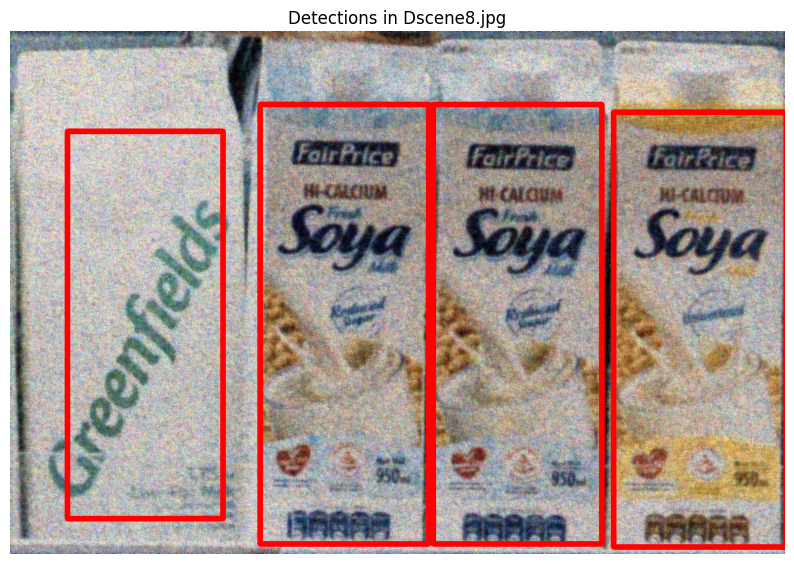

In [ ]:
a = process_scene(snn=0, iou_threshold=0.3, thr=30, lowe_thr=0.7)

### the one with defiency in understanding products and which is which (because of not ideal denoiser)

Product ref26.png - 4 instance(s) found:
  Instance 1 {position: (404.78387, 390.21365), width: 602.077392578125px, height: 226.9564971923828px}
  Instance 2 {position: (137.12174586245882, 384.2136535644531), width: 602.077392578125px, height: 226.9564971923828px}
  Instance 3 {position: (1208.8351119192023, 394.2136535644531), width: 602.077392578125px, height: 226.9564971923828px}
  Instance 4 {position: (708.5108546206824, 364.32669876098635), width: 602.077392578125px, height: 226.9564971923828px}
Product ref27.png - 1 instance(s) found:
  Instance 1 {position: (952.6405575400903, 392.2136535644531), width: 602.077392578125px, height: 226.9564971923828px}
Product ref23.png - 1 instance(s) found:
  Instance 1 {position: (1484.4972405684618, 394.2136535644531), width: 602.077392578125px, height: 226.9564971923828px}



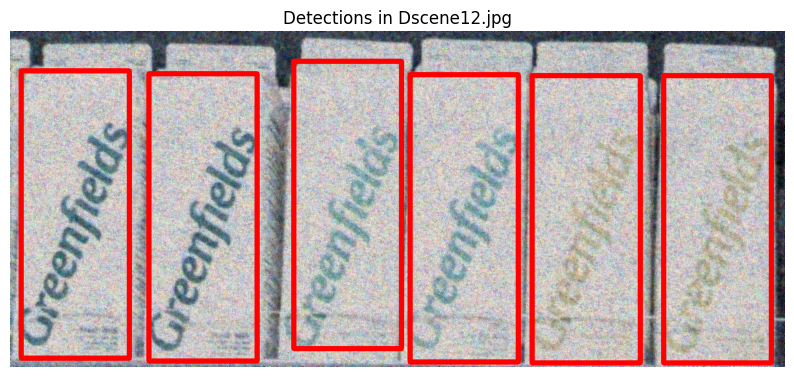

In [ ]:
b = process_scene(snn = 3, iou_threshold=0.3, thr=30, iou= 0.4, lowe_thr=0.7, double_time=True)


### the one with complete power because of using suitable denoised

Product ref26.png - 2 instance(s) found:
  Instance 1 {position: (139.68692, 391.9657), width: 577.8816528320312px, height: 242.0179443359375px}
  Instance 2 {position: (406.79809891550155, 391.9656982421875), width: 577.8816528320312px, height: 242.0179443359375px}
Product ref18.png - 2 instance(s) found:
  Instance 1 {position: (1211.6205781635485, 400.9656982421875), width: 577.8816528320312px, height: 242.0179443359375px}
  Instance 2 {position: (1484.3539926629317, 400.9656982421875), width: 577.8816528320312px, height: 242.0179443359375px}
Product ref27.png - 2 instance(s) found:
  Instance 1 {position: (966.5093994140625, 374.0244421386719), width: 577.8816528320312px, height: 242.0179443359375px}
  Instance 2 {position: (699.7759849146792, 391.9656982421875), width: 577.8816528320312px, height: 242.0179443359375px}



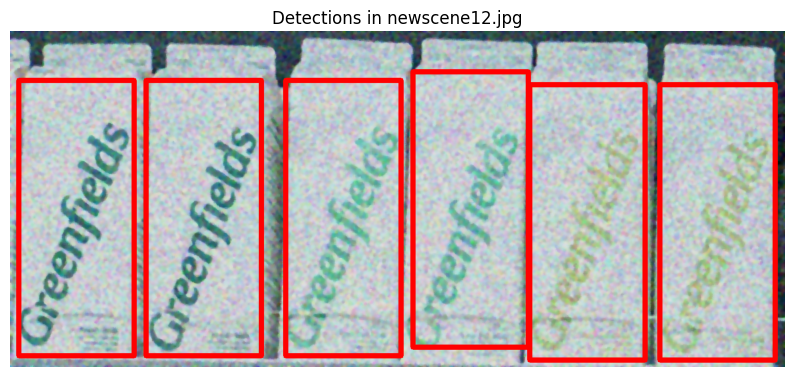

In [ ]:
b = process_scene(snn = 12, iou_threshold=0.3, thr=30, iou= 0.4, lowe_thr=0.7, double_time=True)

Product 0 - 2 instance(s) found:
  Instance 1 {position: (984.1969, 536.339), width: 686.9552001953125px, height: 245.09432983398438px}
  Instance 2 {position: (711.0303730211759, 534.3389892578125), width: 686.9552001953125px, height: 245.09432983398438px}
Product 1 - 2 instance(s) found:
  Instance 1 {position: (1262.363425806949, 537.3389892578125), width: 686.9552001953125px, height: 245.09432983398438px}
  Instance 2 {position: (1492.2966469212581, 537.3389892578125), width: 686.9552001953125px, height: 245.09432983398438px}



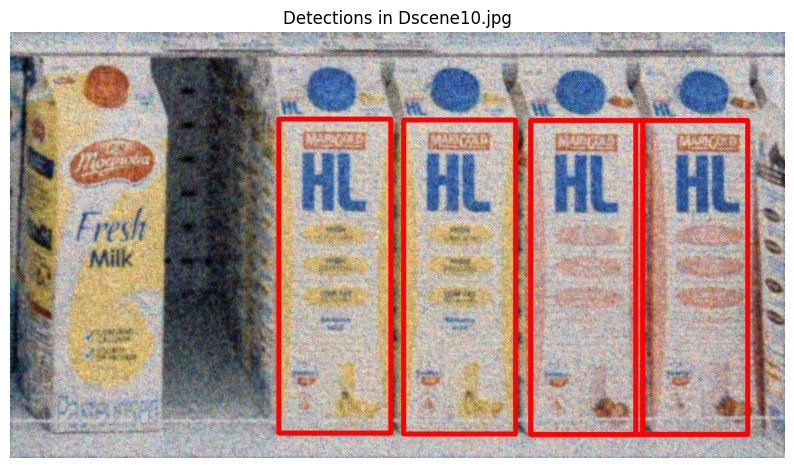

In [ ]:
  c = lets_break_it_down(scene_number=6, iou_threshold=0.2, thr=20, lowe_thr=0.8, shower=False)
  scene_name = list(c.keys())[0]
  initial_detections = c[scene_name]
  scene_img = next(img for name, img, kp, desc in scene_keypoints_descriptors if name == scene_name)
  res_m = perform_multi_instance_detection(initial_detections= c[list(c.keys())[0]], scene_img= scene_img, model_keypoints_descriptors= model_keypoints_descriptors, dist= 5, zncc_threshold=0.9, confidance_thr=0.05)
  report = generate_report(res_m)
  print(report)
  copyim = scene_img.copy()
  draw_bounding_boxes(copyim, res_m)
  plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(copyim, cv2.COLOR_BGR2RGB))
  plt.title(f"Detections in {scene_name}")
  plt.axis('off')
  plt.show()

Product ref17.png - 1 instance(s) found:
  Instance 1 {position: (165.45798, 354.78693), width: 495.3046569824219px, height: 177.01515197753906px}
Product ref25.png - 3 instance(s) found:
  Instance 1 {position: (1343.7406, 375.52698), width: 478.41070556640625px, height: 180.90335083007812px}
  Instance 2 {position: (1143.8942694413033, 372.5269775390625), width: 478.41070556640625px, height: 180.90335083007812px}
  Instance 3 {position: (944.2786720677426, 372.5269775390625), width: 478.41070556640625px, height: 180.90335083007812px}
Product ref24.png - 2 instance(s) found:
  Instance 1 {position: (554.1229, 369.3101), width: 479.4176940917969px, height: 187.19119262695312px}
  Instance 2 {position: (745.3667514198704, 370.3100891113281), width: 479.4176940917969px, height: 187.19119262695312px}
Product ref23.png - 1 instance(s) found:
  Instance 1 {position: (357.8790981895045, 368.3100891113281), width: 479.4176940917969px, height: 187.19119262695312px}



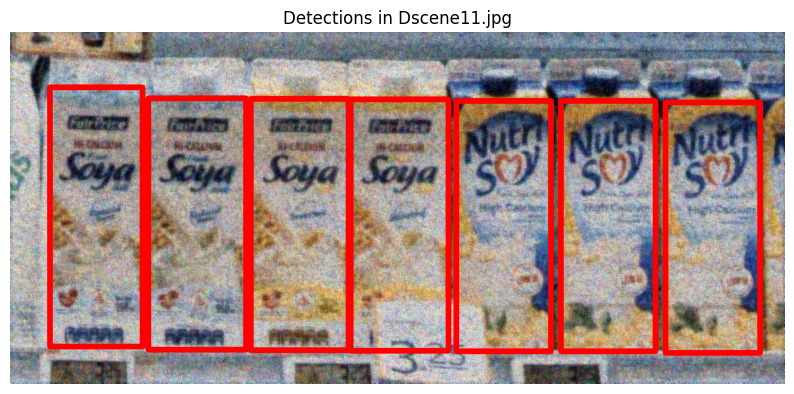

In [ ]:

c = lets_break_it_down(scene_number=7, iou_threshold=0.2, thr=20, lowe_thr=0.8, shower=False)
scene_name = list(c.keys())[0]
initial_detections = c[scene_name]
scene_img = next(img for name, img, kp, desc in scene_keypoints_descriptors if name == scene_name)
  #print(0)
res_m = perform_multi_instance_detection(initial_detections= c[list(c.keys())[0]], scene_img= scene_img, model_keypoints_descriptors= model_keypoints_descriptors, dist= 5, zncc_threshold=0.9, confidance_thr=0.05)
report = generate_report(res_m)
print(report)
copyim = scene_img.copy()
draw_bounding_boxes(copyim, res_m)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(copyim, cv2.COLOR_BGR2RGB))
plt.title(f"Detections in {scene_name}")
plt.axis('off')
plt.show()

### the one with defiency in understanding products and which is which (because of not ideal denoiser)

Product ref19.png - 2 instance(s) found:
  Instance 1 {position: (850.4196, 380.09866), width: 560.2798461914062px, height: 218.908447265625px}
  Instance 2 {position: (629.2565195184004, 380.0986633300781), width: 560.2798461914062px, height: 218.908447265625px}
Product ref20.png - 2 instance(s) found:
  Instance 1 {position: (1364.7113, 389.5319), width: 576.5415649414062px, height: 238.7514190673828px}
  Instance 2 {position: (1117.1291070235402, 377.8192915344238), width: 576.5415649414062px, height: 238.7514190673828px}
Product ref24.png - 1 instance(s) found:
  Instance 1 {position: (363.86080290141854, 364.7750720214844), width: 560.2798461914062px, height: 218.908447265625px}
Product ref26.png - 1 instance(s) found:
  Instance 1 {position: (166.93032515676407, 385.0986633300781), width: 560.2798461914062px, height: 218.908447265625px}



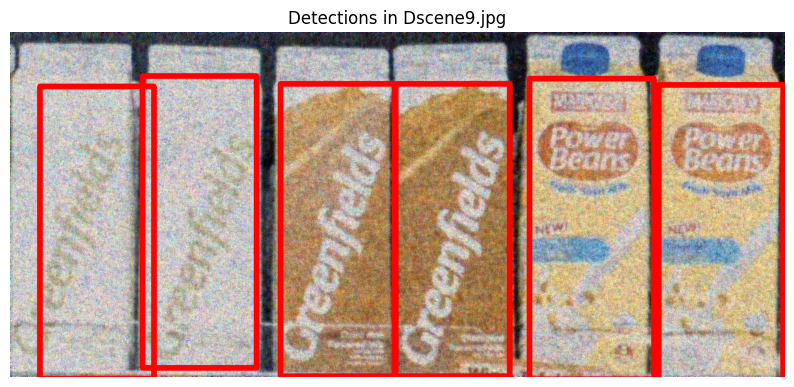

In [ ]:
e = process_scene(snn= 8, iou_threshold=0.2, thr=20, lowe_thr=0.75, double_time= False)


### the one with complete power because of using suitable denoised

Product ref19.png - 2 instance(s) found:
  Instance 1 {position: (847.4834, 372.59775), width: 572.3421630859375px, height: 215.2665557861328px}
  Instance 2 {position: (620.5588603772615, 376.5977478027344), width: 572.3421630859375px, height: 215.2665557861328px}
Product ref20.png - 2 instance(s) found:
  Instance 1 {position: (1364.3679, 382.38538), width: 547.8645629882812px, height: 228.76121520996094px}
  Instance 2 {position: (1128.1055924265008, 371.37209091186526), width: 547.8645629882812px, height: 228.76121520996094px}
Product ref18.png - 2 instance(s) found:
  Instance 1 {position: (370.4494147049753, 362.5290888977051), width: 572.3421630859375px, height: 215.2665557861328px}
  Instance 2 {position: (149.7097842567846, 377.5977478027344), width: 572.3421630859375px, height: 215.2665557861328px}



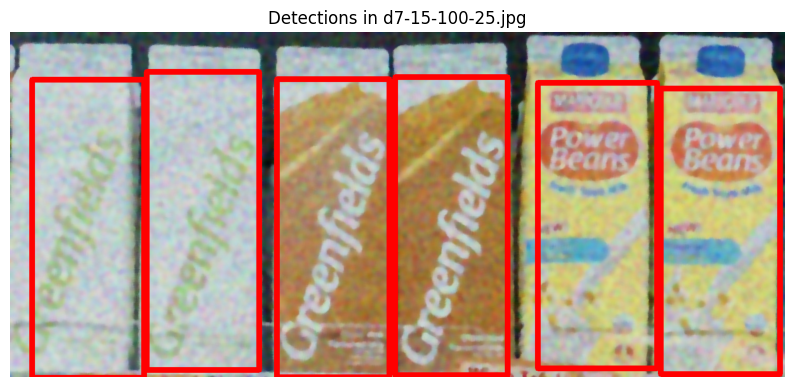

In [ ]:
e = process_scene(snn= 14, iou_threshold=0.2, thr=20, lowe_thr=0.75, double_time= False)

### the one with complete power because of using suitable denoised

Product ref19.png - 2 instance(s) found:
  Instance 1 {position: (620.6016, 374.98413), width: 550.9557495117188px, height: 221.39749145507812px}
  Instance 2 {position: (851.0841562371504, 378.984130859375), width: 550.9557495117188px, height: 221.39749145507812px}
Product ref20.png - 2 instance(s) found:
  Instance 1 {position: (1103.6295, 354.9008), width: 561.3651123046875px, height: 212.89427185058594px}
  Instance 2 {position: (1345.2210083007812, 374.80338638305665), width: 561.3651123046875px, height: 212.89427185058594px}
Product ref18.png - 2 instance(s) found:
  Instance 1 {position: (370.21844482421875, 374.80338638305665), width: 561.3651123046875px, height: 212.89427185058594px}
  Instance 2 {position: (132.1400515907689, 364.4863064575195), width: 550.9557495117188px, height: 221.39749145507812px}



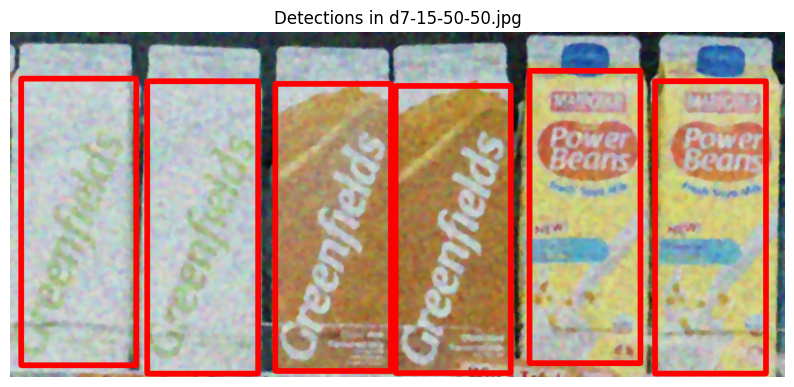

In [ ]:
e = process_scene(snn= 13, iou_threshold=0.2, thr=20, lowe_thr=0.75, double_time= False)


Product ref16.png - 2 instance(s) found:
  Instance 1 {position: (795.0756, 462.37772), width: 598.9173583984375px, height: 216.00103759765625px}
  Instance 2 {position: (1030.490369294819, 464.3777160644531), width: 598.9173583984375px, height: 216.00103759765625px}



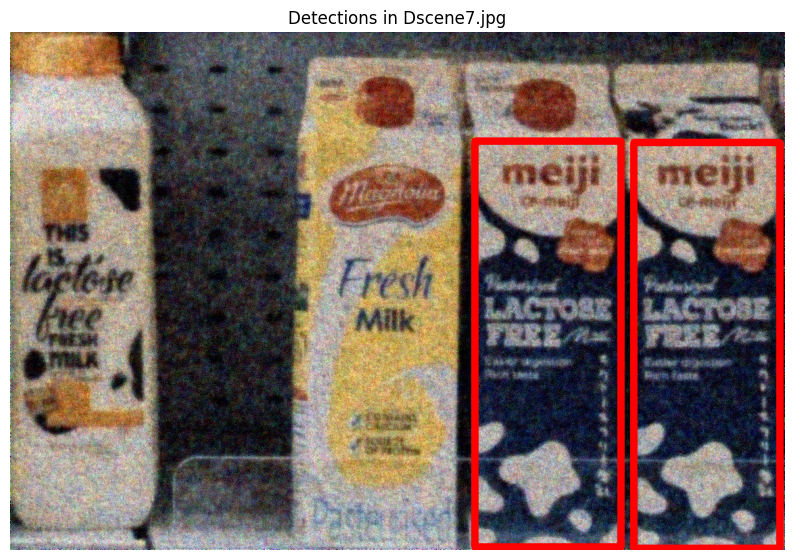

In [ ]:
f = process_scene(snn= 10, iou_threshold=0.2, thr=20, lowe_thr=0.75, confidance_thr= 0.06)

Product ref15.png - 2 instance(s) found:
  Instance 1 {position: (582.8002, 620.5237), width: 902.409912109375px, height: 324.1275939941406px}
  Instance 2 {position: (206.58573190789463, 620.523681640625), width: 902.409912109375px, height: 324.1275939941406px}



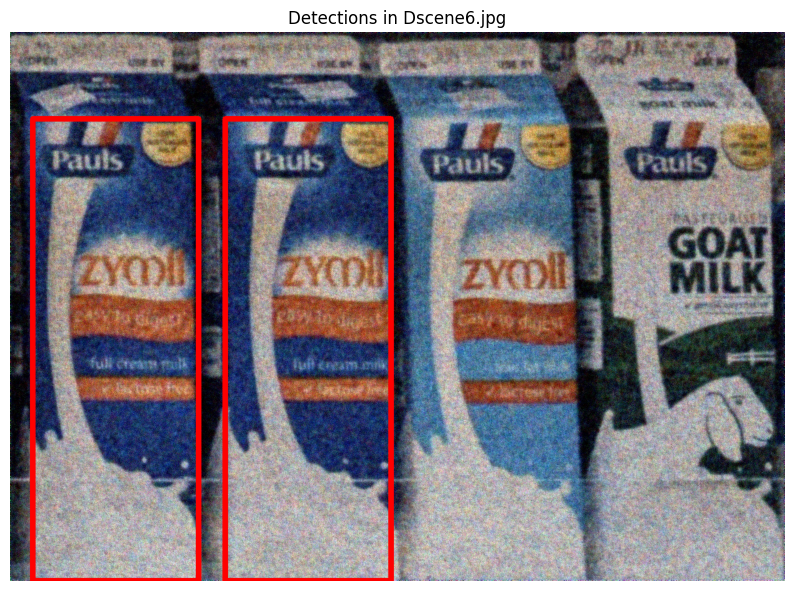

In [ ]:
g = process_scene(snn= 11, iou_threshold=0.2, thr=20, lowe_thr=0.75, confidance_thr=0.06)